<a href="https://colab.research.google.com/github/akimotolab/CMAES_Tutorial/blob/main/4_nonseparability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-Separable 関数 と Covariance Matrix Adaptation

変数ごとに最適化することで最適解が得られる関数をSeparable関数と呼ぶ．前回までに用いたSphere関数やEllipsoid関数は，Separableでありwell-conditioned or ill-conditioned な関数であると言える．

今回は，Separableでない (Non-separableな) 関数の最適化について検討する．

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Non-separable Ellipsoid 関数 での Separable-CMA の振る舞い

#### Ellipsoid 関数

以下，ヘッセ行列の条件数 $10^\texttt{EllipsoidCondition}$ を変更して（$\texttt{EllipsoidCondition} = 0, 1, \dots, 3$程度まで），等高線を確認．Separable な Ellipsoid 関数では，等高線（楕円，各軸の長さがプログラム中のwの逆数）の軸が座標系に平行していることが分かる．

In [15]:
EllipsoidCondition = 1
def ellipsoid(x):
    """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
    w = np.logspace(0, EllipsoidCondition, base=10, num=x.shape[0], endpoint=True)
    return np.sqrt(np.sum(w * x ** 2))

(-1.0, 1.0, -1.0, 1.0)

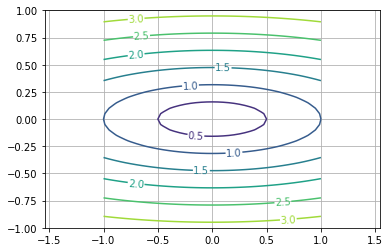

In [16]:
dx, dy = 0.05, 0.05
y, x = np.mgrid[slice(-1, 1 + dy, dy), slice(-1, 1 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = ellipsoid(np.array([x[i,j], y[i,j]]))
        
plt.figure()
CS = plt.contour(x, y, z)
plt.clabel(CS, inline=1, fontsize=10)
plt.grid()
plt.axis('equal')

#### 回転Ellipsoid関数 (回転座標変換後のEllipsoid関数)

ランダムに生成した直交行列 $R$ を用いて，目的関数を $f(x) = f_\text{ellipsoid}(R x)$ と定義すれば，目的関数を回転させた Nonseparable Ellipsoid関数を作ることができる．

上と同様に，\texttt{EllipsoidCondition}を変更させて等高線を作図すると，今度は軸が座標系と平行でないことが分かる．

In [17]:
# Orthogonalization
def gram_schmidt(mat):
    """Return a matrix whose row is orthonormalized"""
    R = mat.copy()
    for i in range(R.shape[0]):
        for j in range(i):
            R[i] = R[i] - np.dot(R[i], R[j]) * R[j]
        R[i] /= np.linalg.norm(R[i])
    return R

In [18]:
EllipsoidCondition = 1
N = 2

# Orthogonal Matrix (Rotation Matrix)
R = gram_schmidt(np.random.randn(N, N))

def rotated_ellipsoid(x):
    """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
    w = np.logspace(0, EllipsoidCondition, base=10, num=x.shape[0], endpoint=True)
    y = np.dot(R, x)
    return np.sqrt(np.sum(w * y ** 2))

(-1.0, 1.0, -1.0, 1.0)

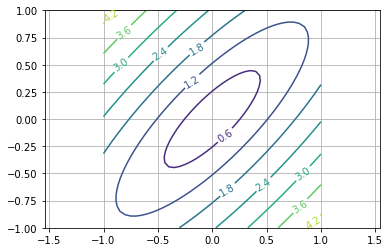

In [19]:
dx, dy = 0.05, 0.05
y, x = np.mgrid[slice(-1, 1 + dy, dy), slice(-1, 1 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = rotated_ellipsoid(np.array([x[i,j], y[i,j]]))
        
plt.figure()
CS = plt.contour(x, y, z)
plt.clabel(CS, inline=1, fontsize=10)
plt.grid()
plt.axis('equal')

前回までに学んだCMAは，Separable CMAと呼ばれ，変数ごとの分散を学習する．

In [20]:
class SepCMAES(object):
    """SepCMA Evolution Strategy with CSA"""
    
    def __init__(self, func, init_mean, init_sigma, nsample):
        """コンストラクタ
        
        Parameters
        ----------
        func : callable
            目的関数 (最小化)
        init_mean : ndarray (1D)
            初期平均ベクトル
        init_sigma : float
            初期ステップサイズ
        nsample : int
            サンプル数
        """
        self.func = func
        self.mean = init_mean
        self.sigma = init_sigma
        self.N = self.mean.shape[0]                     # 探索空間の次元数
        self.arx = np.zeros((nsample, self.N)) * np.nan # 候補解
        self.arf = np.zeros(nsample) * np.nan           # 候補解の評価値
        self.D = np.ones(self.N)
        
        self.weights = np.zeros(nsample)
        self.weights[:nsample//4] = 1.0 / (nsample//4)  # 重み．総和が1
        
        # For CSA
        self.ps = np.zeros(self.N)
        self.cs = 4.0 / (self.N + 4.0)
        self.ds = 1.0 + self.cs
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))
        self.mueff = 1.0 / np.sum(self.weights**2)
        
        # For CMA
        self.cmu = self.mueff / (4 * self.N + self.mueff)
        
    def sample(self):
        """候補解を生成する．"""
        self.arx = self.mean + self.sigma * np.random.normal(size=self.arx.shape) * np.sqrt(self.D)
    
    def evaluate(self):
        """候補解を評価する．"""
        for i in range(self.arf.shape[0]):
            self.arf[i] = self.func(self.arx[i])
        
    def update_param(self):
        """パラメータを更新する．"""
        idx = np.argsort(self.arf)  # idx[i]は評価値がi番目に良い解のインデックス
        # 進化パスの更新 (平均ベクトル移動量の蓄積)
        self.ps = (1 - self.cs) * self.ps + np.sqrt(self.cs * (2 - self.cs) * self.mueff) * np.dot(self.weights, (self.arx[idx] - self.mean)) / np.sqrt(self.D) / self.sigma
        # 共分散行列の対角要素を更新
        self.D = (1 - self.cmu) * self.D + self.cmu * np.dot(self.weights, (self.arx[idx] - self.mean) ** 2) / self.sigma ** 2
        # 進化パスの長さが，ランダム関数の下での期待値よりも大きければステップサイズを大きくする．
        self.sigma = self.sigma * np.exp(self.cs / self.ds * (np.linalg.norm(self.ps) / self.chiN - 1))        
        self.mean += np.dot(self.weights, (self.arx[idx] - self.mean))

回転Ellipsoid関数で実験

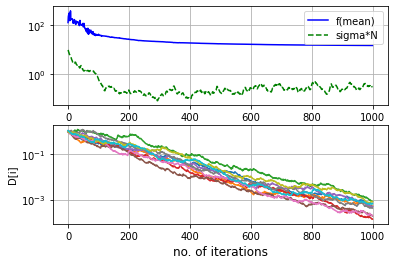

In [21]:
EllipsoidCondition = 6
N = 10
R = gram_schmidt(np.random.randn(N, N))
def rotated_ellipsoid(x):
    """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
    w = np.logspace(0, EllipsoidCondition, base=10, num=x.shape[0], endpoint=True)
    y = np.dot(R, x)
    return np.sqrt(np.sum(w * y ** 2))

es = SepCMAES(func=rotated_ellipsoid,            
           init_mean=np.zeros(10),  
           init_sigma=1, 
           nsample=10)             

maxiter = 1000
mean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
diagC = np.zeros((maxiter, es.N)) * np.nan

for i in range(maxiter):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    sigmaN[i] = es.sigma * es.N
    diagC[i] = es.D
    
plt.subplot(211)
plt.semilogy(mean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best')
plt.subplot(212)
plt.semilogy(diagC)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('D[i]')
plt.grid()

条件数を変えて収束曲線を比較

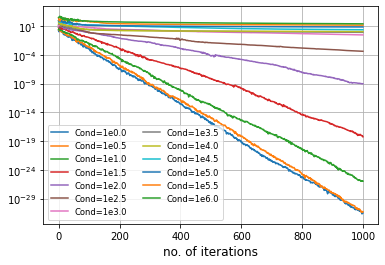

In [ ]:
EllCondArray = np.linspace(0, 6, num=13, endpoint=True)
for j in range(EllCondArray.shape[0]):
    EllipsoidCondition = EllCondArray[j]
    N = 10
    R = gram_schmidt(np.random.randn(N, N))
    def rotated_ellipsoid(x):
        """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
        w = np.logspace(0, EllipsoidCondition, base=10, num=x.shape[0], endpoint=True)
        y = np.dot(R, x)
        return np.sqrt(np.sum(w * y ** 2))

    es = SepCMAES(func=rotated_ellipsoid,    
               init_mean=np.zeros(10), 
               init_sigma=1,
               nsample=10)                 

    maxiter = 1000
    mean = np.zeros(maxiter) * np.nan
    sigmaN = np.zeros(maxiter) * np.nan
    for i in range(maxiter):
        es.sample()
        es.evaluate()
        es.update_param()
        mean[i] = es.func(es.mean)
        sigmaN[i] = es.sigma * es.N
    
    plt.semilogy(mean, label='Cond=1e'+str(EllipsoidCondition))

plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best', fontsize='small', ncol=2)

観察される結果

* 条件数が大きくなると収束速度が著しく低下する
* CSA-ESと変わらない

原因

* 変数ごとの分散しか学習していない ==> 解生成分布は座標軸に沿った楕円形
* 等高線(楕円)が座標軸に沿っていない(回転している)場合，上記の弱点により優れた解を生成することができない

## 多変量正規分布の性質

#### 生成方法，期待値，共分散行列の確認

多変量（$d$変量）標準正規分布 $\mathcal{N}(0, I)$ に従う確率ベクトル$z = (z_1, \dots, z_d)$は，$d$個の独立な標準正規分布に従う確率変数 $z_i \sim \mathcal{N}(0, 1)$ を並べたベクトルであり，そのように生成することができる．このとき，期待値は$\mathbb{E}[z] = 0$，共分散行列は$\mathbb{E}[z z^\mathrm{T}] = I$となることが容易に確認される．
また，平均ベクトルが非ゼロな正規分布 $\mathcal{N}(m, \sigma^2 I)$ については，$x = m + \sigma z$ と生成される．これについての期待値と共分散行列も同様に，
$$\begin{aligned}
\mathbb{E}[x] &= \mathbb{E}[m + \sigma z] = m + \sigma \mathbb{E}[z] = m
\\
\mathbb{E}[(x - m)(x - m)^\mathrm{T}] &= \sigma^2 \mathbb{E}[z z^\mathrm{T}] = \sigma^2 I
\end{aligned}$$
となることが分かる．

共分散行列$\Sigma$が対角行列である場合，多変量正規分布 $\mathcal{N}(m, \Sigma)$ に従う確率ベクトルは，上のように生成した z を用いて $x = m + \sqrt{\Sigma} z$ と生成することができる．ここで，$\Sigma$は対角行列なので，$\sqrt{\Sigma}$は$\Sigma$の対角要素の平方根を並べた対角行列にほかならない．このとき，期待値と共分散行列は
$$\begin{aligned}
\mathbb{E}[x] &= \mathbb{E}[m + \sqrt{\Sigma} z] = m + \sqrt{\Sigma} \mathbb{E}[z] = m \\
\mathbb{E}[(x-m) (x-m)^\mathrm{T}] &= \mathbb{E}[\sqrt{\Sigma} z (\sqrt{\Sigma} z)^\mathrm{T}] = \sqrt{\Sigma} \mathbb{E}[z z^\mathrm{T}] \sqrt{\Sigma} = \sqrt{\Sigma} I \sqrt{\Sigma} = \Sigma \\
\end{aligned}$$
となることが確認できる．

共分散行列$\Sigma$が対角行列に限らない一般の場合，共分散行列は定義から非負定値対称行列（全ての固有値が非負となる対称行列）であることが求められる．行列の平方根 $\sqrt{\Sigma}$ は$\Sigma = \sqrt{\Sigma} \sqrt{\Sigma}$となる非負定値対称行列であり，$\Sigma$が非負定値対称行列のとき一意に存在する．多変量正規分布 $\mathcal{N}(0, \Sigma)$ に従う確率ベクトルは，上のように生成した z を用いて $x = \sqrt{\Sigma} z$ と生成することができる．なお，期待値，共分散行列については，$\Sigma$が対角行列の場合の導出において，$\Sigma$が対角行列であるという事実を使っていないことから，同様に導けることは容易に分かるであろう．

#### 基本性質
これまでの議論でも用いているが，ここで簡単に正規分布の基本的な性質をまとめておく．

まず，k個の正規分布に従う確率ベクトル$x_i \sim \mathcal{N}(m_i, \Sigma_i)$（$i = 1, \dots, k$）が互いに独立であるとき，それらの加重和もまた正規分布
$$
\begin{aligned}
\sum_{i=1}^{k} w_i x_i \sim \mathcal{N}\left( \sum_{i=1}^{k} w_i m_i, \sum_{i=1}^{k} w_i^2 \Sigma_i \right)
\end{aligned}
$$
に従う．これを正規分布の安定性という．なお，平均ベクトルや共分散行列が上の形になることは，正規分布以外の分布についても成立する．

多変量正規分布の射影後もまた正規分布となる．例えば，$d$変量正規分布に従う確率ベクトルが$x \sim \mathcal{N}(m, \Sigma)$のとき，$k \times d$次元行列$A$のもとで，
$$
\begin{aligned}
A x \sim \mathcal{N}(A m, A \Sigma A^\mathrm{T})
\end{aligned}
$$
となる．
特に，$k = 1$ のとき，ベクトル$a$を用いて$A = a^\mathrm{T}$と書けば，
$$
\begin{aligned}
a^\mathrm{T} x \sim \mathcal{N}(a^\mathrm{T} m, a^\mathrm{T} \Sigma a)
\end{aligned}
$$
となる．

正規分布について，無相関であることと独立であることは等価である．すなわち，二つの正規分布に従う確率変数$x \sim \mathcal{N}(m_x, \Sigma_x)$と$y \sim \mathcal{N}(m_y, \Sigma_y)$が与えられたとき，$\mathbb{E}[(x - m_x)(y - m_y)] = 0$ならば，$x$と$y$は独立である．なお，一般の確率分布に対しては，独立ならば無相関であるが，無相関であっても独立であるとは限らないことに注意されたい．この事実を用いると，多変量標準正規分布に従う確率ベクトル$z \sim \mathcal{N}(0, I)$（$z$の各要素は互いに独立）に対して，直交行列 $B = [b_1, \dots, b_d]$ を左からかけて作られる
$\tilde{z} = B z$ について，
$$
\mathbb{E}[\tilde{z} \tilde{z}^\mathrm{T}] = B \mathbb{E}[z z^\mathrm{T}] B^\mathrm{T} = B B^\mathrm{T} = I
$$
が成立することから，$\tilde{z}$の各要素 $\tilde{z}_i = b_i^\mathrm{T} z$ は，互いに無相関であり，すなわち互いに独立であることを意味する．


#### 密度関数，等高線，固有値分解との関係

共分散行列が正定値（全ての固有値が正）であると仮定する．CMA-ESについて考える限り，正定値を仮定しても何ら問題はない．このとき，多変量正規分布$\mathcal{N}(m, \Sigma)$の確率密度関数は
$$
p(x; m, \Sigma) = \left((2\pi)^d\mathrm{det}(\Sigma)\right)^{-\frac{1}{2}} \exp\left( - \frac{1}{2} (x - m)^\mathrm{T} \Sigma^{-1} (x - m) \right)
$$
と表される．すなわち，等高線は中心が$m$の楕円
$$
(x - m)^\mathrm{T} \Sigma^{-1} (x - m) = \gamma^2
$$
で表される．なお，$\gamma$は適当な正の値である．

この楕円の各軸の長さや向きは，共分散行列の固有値分解により表すことができる．
$\Sigma$の固有値を小さい方から順に$\lambda_1, \dots, \lambda_d$とし，これを並べてた対角行列を$\Lambda$とする．また，対応する単位固有ベクトルを$b_1, \dots, b_d$とし，これを並べた直交行列を$B = [b_1, \dots, b_d]$と表す．このとき，楕円の各軸の長さは$\gamma\lambda_1, \dots, \gamma\lambda_d$であり，その方向は$\pm b_1, \dots, \pm b_d$で表される．

なお，共分散行列やその平方根は，固有値分解を用いて
$$\begin{aligned}
\Sigma &= B \Lambda B^\mathrm{T} \\
\sqrt{\Sigma} &= B \sqrt{\Lambda} B^\mathrm{T} 
\end{aligned}$$
と表すことができる．ここで，$\Lambda$は対角行列であるため，$\sqrt{\Lambda}$は$\Lambda$の対角要素の平方根を並べた行列であり，容易に計算できる．この事実を用いると，
$$
x = m + \sqrt{\Sigma} z = m + B \sqrt{\Lambda} B^\mathrm{T} z = m + \sum_{i=1}^{d} \sqrt{\lambda_i} (b_i^\mathrm{T} z) b_i
$$
と書き下すことができる．ここで，$\tilde{z} = (b_1^\mathrm{T} z, \dot, b_d^\mathrm{T} z)$と書けば，$\tilde{z}$は標準正規分布に従うことから，
$$
x \sim m + \sum_{i=1}^{d} \mathcal{N}(0, \lambda_i) b_i
$$
と書くことができ，これは平均ベクトルに対し，共分散行列の各固有ベクトルの方向に，各固有値を分散として持つ正規分布を足し合わせることで表されたもの，と解釈することができる．

#### 正規分布のノルムの分布

正規分布の密度関数は中心が最大値をとることから，「平均ベクトル周辺に多く分布する」と思われやすいが，これは大きな誤解である．

上記の議論において，等高線の形（楕円型）であることに着目したが，具体的な広がりを表す$(x - m)^\mathrm{T} \Sigma^{-1} (x - m) = \gamma^2$の右辺の$\gamma^2$については言及していない．ここでは，この$\gamma^2$がどの程度の値となりやすいのか，考える．まず，$x - m = \sqrt{\Sigma} z$を代入すれば，$(x - m)^\mathrm{T} \Sigma^{-1} (x - m) = \|z\|_2^2$であり，$\|z\|_2^2 = \sum_{i=1}^{d} z_i^2$ は自由度$d$のカイ二乗分布に従うことが知られている．すなわち，上述の$\gamma^2$の典型的な値は，自由度$d$のカイ二乗分布の典型的な値で与えられるといえる．自由度$d$のカイ二乗分布の期待値は$d$，分散は$2d$である．このとき，$\|z\|_2^2 / d$の期待値は$1$，標準偏差は$\sqrt{2 / d}$ であることから，$d$が大きくなるほど，$\|z\|_2^2 / d$はほとんど$1$に近い値しか取らなくなることを意味する．すなわち，z は半径が$\sqrt{d}$の超球の表面付近に集中しており，内部にはほとんど存在しないことを表している．また，以上の議論から$\gamma^2$の典型的な値は$\gamma^2 = d$であるといえる．

上のような誤解を招く原因について言及しておく．
そのために，半径$r$の球と半径$(1 - \epsilon)r$の球の測度の比を考える．すると，
後者は前者の$(1 - \epsilon)^d$倍小さな値であることが容易に導かれる．$\epsilon$がどんなに小さくても，$d$が大きくなればこの値は$0$に近づく．すなわち，半径$r$の球の測度は，ほとんどがその表面付近（半径$(1 - \epsilon)r$の球との間）にあるといえる．正規分布はあくまで密度が高いだけであり，雑に言えば密度と測度（体積を一般化したものと考えればよい）の積が確率を表すが，上の議論から中心付近の測度は限りなく$0$に近いため，実際にはほとんどが球表面上に分布することになる．


## 共分散行列の更新 (変数間依存性を考慮)

#### アイディア
解生成分布が(座標系に依存しない)任意の楕円形を取れるように，共分散行列($N \times N$ 正定値対称行列)を学習する．

#### 具体的な更新方法

基本的には Separable-CMA と同様であるば，非対角要素も学習する点が異なる．

共分散行列$\Sigma = \sigma^2 C$と表されるとする．
各イテレーションにおいて，候補解は$x_{i} \sim m + \sigma \sqrt{C} \mathcal{N}(0, I) \sim \mathcal{N}(m, \sigma^2 C)$に従って生成される．各解の目的関数の評価後，その昇順にソートし，$i$番目に優れた解を$x_{i:\lambda}$と表記する．このとき，共分散行列の更新式は
$$
C \leftarrow (1 - c_\mu)C + c_\mu \sum_{i=1}^{\lambda} w_i \left(\frac{x_{i:\lambda} - m}{\sigma}\right)\left(\frac{x_{i:\lambda} - m}{\sigma}\right)^\mathrm{T}
$$
で与えられる．ここで，$c_\mu$は学習率を表す．
また，右辺に現れる$m$，$\sigma$，$C$はいずれも解生成時のパラメータ（更新前のパラメータ）であることに注意されたい．

#### 解説

解釈についても，共分散行列が対角行列に限らない点を除けば，Separable-CMAと同じである．
例えば重みが $w_1 = \dots = w_{\mu} = 1/\mu$，$w_{\mu + 1} = \dots = w_{\lambda}= 0$の場合（$\mu = \lfloor \lambda / 4 \rfloor$），上位1/4個の解候補についての$C$の最尤推定（$m$, $\sigma$は既知）をしているとみなせる．また，別の解釈として，目的関数の正規分布のもとでの自然勾配に従っていると解釈することもできる[2]．

[2] Akimoto, Y., Nagata, Y., Ono, I. et al. Theoretical Foundation for CMA-ES from Information Geometry Perspective. Algorithmica 64, 698–716 (2012). https://doi.org/10.1007/s00453-011-9564-8

#### 不偏性の確認

不偏性についても，Separable-CMA と同様に確認できる．

まず，$x_{i:\lambda}$ が独立に $\mathcal{N}(m, \sigma^2 C)$に従うことを考えれば，
$$
\frac{(x_{i:\lambda} - m)}{\sigma} \sim \mathcal{N}(0, C)
$$
に従うことが分かる．このとき，更新式第二項の期待値は
$$\begin{aligned}
\mathbb{E}\left[ 
  \sum_{i=1}^{\lambda} w_i \left(\frac{x_{i:\lambda} - m}{\sigma}\right)\left(\frac{x_{i:\lambda} - m}{\sigma}\right)^\mathrm{T}
\right]
&= 
\sum_{i=1}^{\lambda} w_i \mathbb{E}\left[ \left(\frac{x_{i:\lambda} - m}{\sigma}\right)\left(\frac{x_{i:\lambda} - m}{\sigma}\right)^\mathrm{T} \right]
\\
&= 
  \sum_{i=1}^{\lambda} w_i C
\\
&= 
  C
\end{aligned}
$$
となることから，更新後の$C$の期待値は更新前の$C$となることが分かる．

#### プログラム

In [22]:
class CMAES(object):
    """CMA Evolution Strategy with CSA"""
    
    def __init__(self, func, init_mean, init_sigma, nsample):
        """コンストラクタ
        
        Parameters
        ----------
        func : callable
            目的関数 (最小化)
        init_mean : ndarray (1D)
            初期平均ベクトル
        init_sigma : float
            初期ステップサイズ
        nsample : int
            サンプル数
        """
        self.func = func
        self.mean = init_mean
        self.sigma = init_sigma
        self.N = self.mean.shape[0]                     # 探索空間の次元数
        self.arx = np.zeros((nsample, self.N)) * np.nan # 候補解
        self.arf = np.zeros(nsample) * np.nan           # 候補解の評価値
        
        self.D = np.ones(self.N) # 共分散行列の固有値
        self.B = np.eye(self.N)  # 共分散行列の固有ベクトル
        self.C = np.dot(self.B * self.D, self.B.T) # 共分散行列
        
        self.weights = np.zeros(nsample)
        self.weights[:nsample//4] = 1.0 / (nsample//4)  # 重み．総和が1
        
        # For CSA
        self.ps = np.zeros(self.N)
        self.mueff = 1.0 / np.sum(self.weights**2)
        self.cs = (2.0 + self.mueff) / (self.N + 3.0 + self.mueff)
        self.ds = 1.0 + self.cs + max(1.0, np.sqrt(self.mueff / self.N))
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))
        
        # For CMA
        self.cmu = self.mueff / (self.N ** 2 / 2 + self.N + self.mueff)
        
    def sample(self):
        """候補解を生成する．"""
        self.arz = np.random.normal(size=self.arx.shape)
        self.ary = np.dot(np.dot(self.arz, self.B) * np.sqrt(self.D), self.B.T)
        self.arx = self.mean + self.sigma * self.ary
    
    def evaluate(self):
        """候補解を評価する．"""
        for i in range(self.arf.shape[0]):
            self.arf[i] = self.func(self.arx[i])
        
    def update_param(self):
        """パラメータを更新する．"""
        idx = np.argsort(self.arf)  # idx[i]は評価値がi番目に良い解のインデックス
        # 進化パスの更新 (平均ベクトル移動量の蓄積)
        self.ps = (1 - self.cs) * self.ps + np.sqrt(self.cs * (2 - self.cs) * self.mueff) * np.dot(self.weights, self.arz[idx])
        # 共分散行列の更新
        self.C = (1 - self.cmu) * self.C + self.cmu * np.dot(self.ary[idx].T * self.weights, self.ary[idx])
        # 共分散行列の固有値分解
        self.D, self.B = np.linalg.eigh(self.C)

        # 進化パスの長さが，ランダム関数の下での期待値よりも大きければステップサイズを大きくする．
        self.sigma = self.sigma * np.exp(self.cs / self.ds * (np.linalg.norm(self.ps) / self.chiN - 1))        
        self.mean += np.dot(self.weights, self.arx[idx] - self.mean)

#### rotated Ellipsoidでの振る舞い

以下，D は共分散行列の固有値，diagCは共分散行列の対角成分（各要素の分散）を表す．

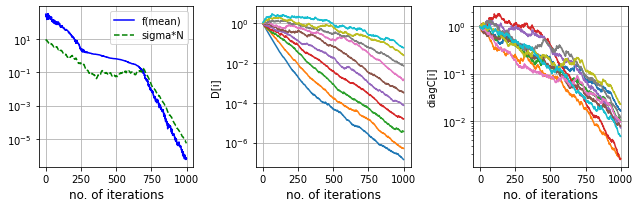

In [23]:
EllipsoidCondition = 6
N = 10
R = gram_schmidt(np.random.randn(N, N))

es = CMAES(func=rotated_ellipsoid,            
           init_mean=np.zeros(10),  
           init_sigma=1, 
           nsample=10)             

maxiter = 1000
mean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
D = np.zeros((maxiter, es.N)) * np.nan
diagC = np.zeros((maxiter, es.N)) * np.nan

for i in range(maxiter):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    sigmaN[i] = es.sigma * es.N
    D[i] = es.D
    diagC[i] = np.diag(es.C)

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.semilogy(mean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best')
plt.subplot(132)
plt.semilogy(D)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('D[i]')
plt.grid()
plt.subplot(133)
plt.semilogy(diagC)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('diagC[i]')
plt.grid()
plt.tight_layout()

#### separable Ellipsoidでの振る舞い

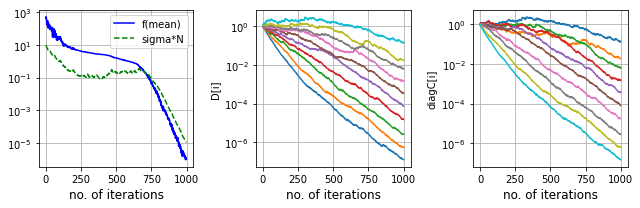

In [ ]:
EllipsoidCondition = 6

es = CMAES(func=ellipsoid,            
           init_mean=np.zeros(10),  
           init_sigma=1, 
           nsample=10)             

maxiter = 1000
mean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
D = np.zeros((maxiter, es.N)) * np.nan
diagC = np.zeros((maxiter, es.N)) * np.nan

for i in range(maxiter):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    sigmaN[i] = es.sigma * es.N
    D[i] = es.D
    diagC[i] = np.diag(es.C)

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.semilogy(mean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best')
plt.subplot(132)
plt.semilogy(D)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('D[i]')
plt.grid()
plt.subplot(133)
plt.semilogy(diagC)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('diagC[i]')
plt.grid()
plt.tight_layout()

* Separable Ellipsoid と Rotated Ellipsoid で，固有値の振る舞いが変わらない．
* 共分散行列の対角要素をみると大きく異なる

#### separable Ellipsoid と rotated Ellipsoid の比較

Text(0.5, 1.0, 'rotated ellipsoid')

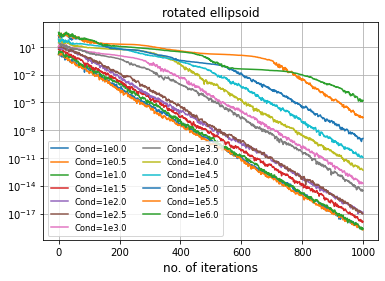

In [ ]:
EllCondArray = np.linspace(0, 6, num=13, endpoint=True)
for j in range(EllCondArray.shape[0]):
    EllipsoidCondition = EllCondArray[j]
    N = 10
    R = gram_schmidt(np.random.randn(N, N))
    es = CMAES(func=rotated_ellipsoid,    
               init_mean=np.zeros(10), 
               init_sigma=1,
               nsample=10)                 

    maxiter = 1000
    mean = np.zeros(maxiter) * np.nan
    sigmaN = np.zeros(maxiter) * np.nan
    for i in range(maxiter):
        es.sample()
        es.evaluate()
        es.update_param()
        mean[i] = es.func(es.mean)
        sigmaN[i] = es.sigma * es.N
    
    plt.semilogy(mean, label='Cond=1e'+str(EllipsoidCondition))

plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best', fontsize='small', ncol=2)
plt.title('rotated ellipsoid')

Text(0.5, 1.0, 'separable ellipsoid')

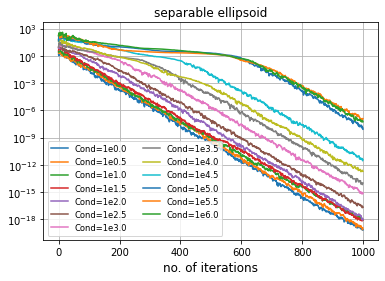

In [ ]:
EllCondArray = np.linspace(0, 6, num=13, endpoint=True)
for j in range(EllCondArray.shape[0]):
    EllipsoidCondition = EllCondArray[j]
    N = 10

    es = CMAES(func=ellipsoid,    
               init_mean=np.zeros(N), 
               init_sigma=1,
               nsample=10)                 

    maxiter = 1000
    mean = np.zeros(maxiter) * np.nan
    sigmaN = np.zeros(maxiter) * np.nan
    for i in range(maxiter):
        es.sample()
        es.evaluate()
        es.update_param()
        mean[i] = es.func(es.mean)
        sigmaN[i] = es.sigma * es.N
    
    plt.semilogy(mean, label='Cond=1e'+str(EllipsoidCondition))

plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best', fontsize='small', ncol=2)
plt.title('separable ellipsoid')

Separable-CMAとことなり，非対角成分を考慮したCMAは rotated Ellipsoid と separable Ellipsoid で同様の振る舞いを示す．